## Setup for google colaboratory users
- If you use google colaboratory for your programming environment, please run the below. 
- You have to give a permission to refer the data in your google drive to import real data you have.

In [1]:
# Mount Google Drive to read files in Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


- Change "TS" to your own folder name. (the folder where you save the data)

In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

First, import the libraries.

In [3]:
# Install the necessary libraries
!pip install -U statsmodels
#The code below is for displaying Japanese, install if you need.
#!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [4]:
# Code 3.1
import collections
import math

import cvxpy
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm, t
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR

In [6]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
#import japanize_matplotlib

Next, load the data. The data to be loaded at first is the GDP gap published by the Cabinet Office.

In [5]:
# Code 3.2
# Load the data
gap = pd.read_excel("data_3_eng.xlsx", sheet_name="GDPgap(cabinet)&Tankan(BoJ)", header=[0])
caogap = gap.iloc[:, 1]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="QS")

We conduct out-of-sample forecasting of the GDP gap with AR(1) model. Training period is set to 40 quarters(set with "PERIOD")、forecast horizon is set to 1 quarter(set with "H")。Besides, the lag order of AR model can be adjusted by changing the value of "L" in the code. By using different windos including fixed window, expanding window and rolling window, we can conduct out-of-sample forecasts, and compute Figure 3.2.

In [7]:
# Code 3.3
# Out-of-sample forecast with AR(1) model
PERIOD = 40  # Sample size of training data（40 quarters）
H = 1  # Forecast horizon（1 quarter）
L = 1  # Lag order of AR model（1 quarter）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)


def train_and_predict_ar_model(train_x, train_y, test_x, test_y):
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    return forecast, sqe


# Fixed window
predict_result1_list, sqe_result1_list = [], []
predict_result1 = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result1 = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for ll in range(1, L + 1, 1):
        # Training data
        train_x_lagged = pd.DataFrame(
            np.ravel(
                (data_x[L - ll : L - ll + PERIOD]).to_numpy()
            )
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
        train_y = data_y[0 + H + (L - 1) : 0 + H + PERIOD + (L - 1)]
        # Test data
        test_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll + PERIOD : i + L - ll + PERIOD + 1]
                ).to_numpy()
            )
        )
        test_x = pd.concat([test_x, test_x_lagged], axis=1)
        test_y = data_y[
            i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1
        ]
    predict_result1[i], sqe_result1[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result1_list.append(predict_result1)
sqe_result1_list.append(sqe_result1)
print(f"MSFE for Fixed window: {np.mean(sqe_result1_list)}")

# Expanding window
predict_result2_list, sqe_result2_list = [], []
predict_result2 = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result2 = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for ll in range(1, L + 1, 1):
        # Training data
        train_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[L - ll : i + L - ll + PERIOD]
                ).to_numpy()
            )
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
        train_y = data_y[0 + H + (L - 1) : i + H + PERIOD + (L - 1)]
        # Test data
        test_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll + PERIOD : i + L - ll + PERIOD + 1]
                ).to_numpy()
            )
        )
        test_x = pd.concat([test_x, test_x_lagged], axis=1)
        test_y = data_y[
            i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1
        ]
    predict_result2[i], sqe_result2[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result2_list.append(predict_result2)
sqe_result2_list.append(sqe_result2)
print(f"MSFE for expanding data: {np.mean(sqe_result2_list)}")

# Rolling window
predict_result3_list, sqe_result3_list = [], []
predict_result3 = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result3 = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for ll in range(1, L + 1, 1):
        # Training data
        train_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll : i + L - ll + PERIOD]
                ).to_numpy()
            )
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
        train_y = data_y[i + H + (L - 1) : i + H + PERIOD + (L - 1)]
        # Test data
        test_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll + PERIOD : i + L - ll + PERIOD + 1]
                ).to_numpy()
            )
        )
        test_x = pd.concat([test_x, test_x_lagged], axis=1)
        test_y = data_y[
            i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1
        ]
    predict_result3[i], sqe_result3[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result3_list.append(predict_result3)
sqe_result3_list.append(sqe_result3)
print(f"MSFE for rolling data: {np.mean(sqe_result3_list)}")

MSFE for Fixed window: 1.9253443950003313
MSFE for expanding data: 1.97651327358338
MSFE for rolling data: 2.3274893086789317


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_text(s, 0, flags=flags)


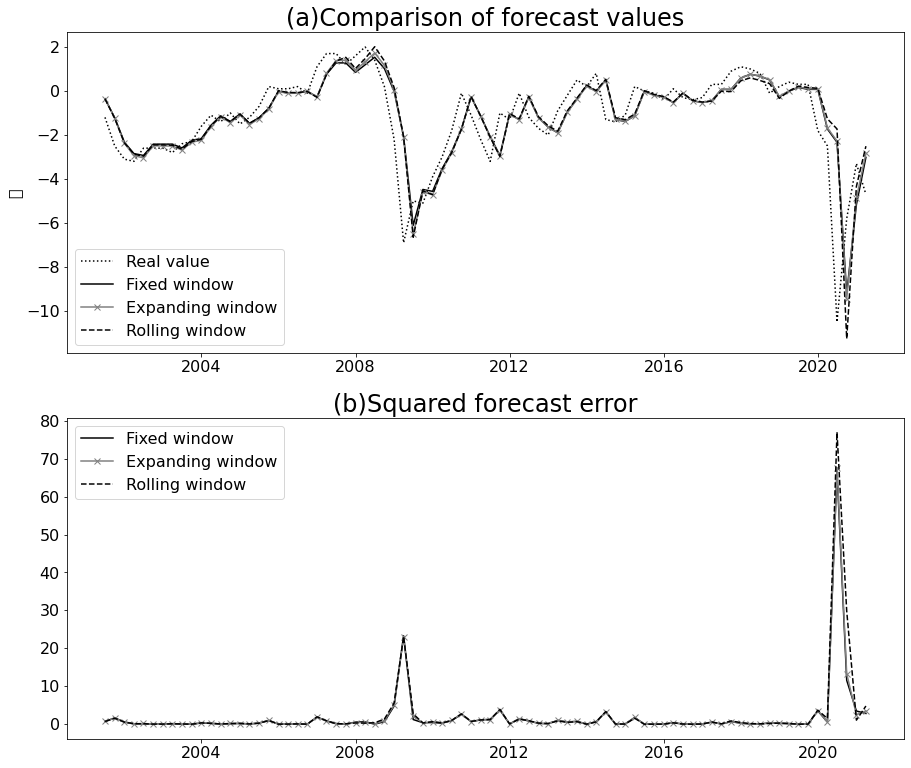

In [8]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)Comparison of forecast values", fontsize=24)
ax1.plot(dti[H + PERIOD :], caogap[H + PERIOD :].to_numpy(), label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result1_list), label="Fixed window", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result2_list), label="Expanding window", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result3_list), label="Rolling window", color="black", linestyle="dashed")
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)Squared forecast error", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result1_list), label="Fixed window", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result2_list), label="Expanding window", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result3_list), label="Rolling window", color="black", linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

Select the type of window(fixed, expanding, or rolling): expanding


(0.0, 5.0)

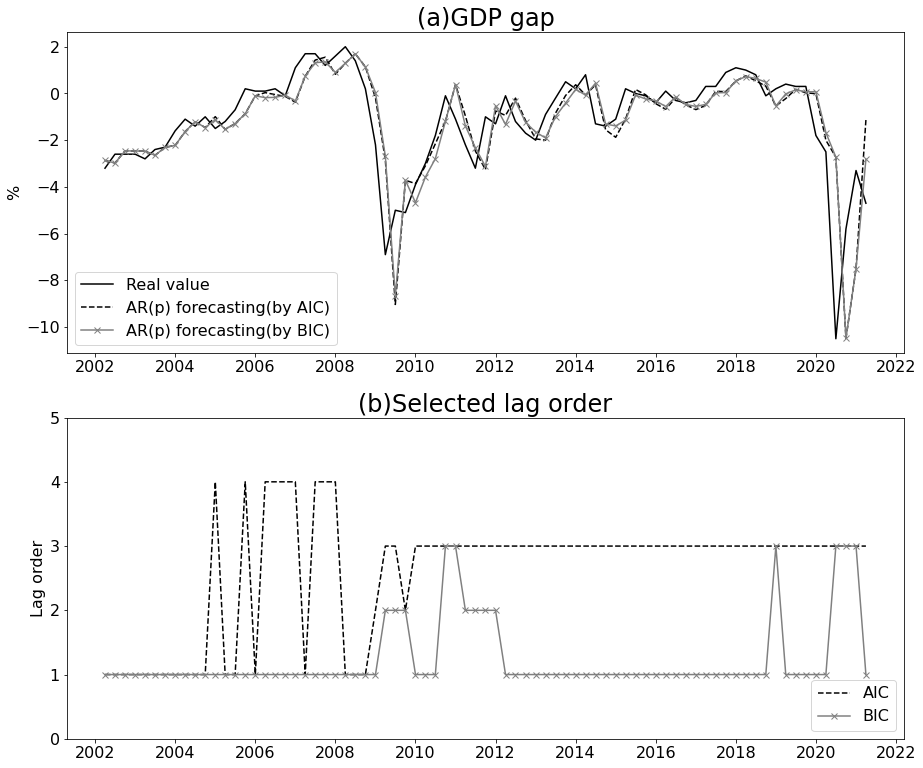

In [15]:
#####
##!!!scheme特殊确认
# Out-of-sample forecast with AR(p) model
scheme = str(input("Select the type of window(fixed, expanding, or rolling): "))
predict_result_list, sqe_result_list, aic_result_list, bic_result_list = [], [], [], []
PERIOD = 40  # Sample size of training data（40 quarters）
H = 1  # Forecast horizon（1 quarter）
MAX_L = 4  # Maximum lag order of AR model（4 quarter）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)

for l in range(1, MAX_L + 1):
    predict_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    sqe_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    aic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    bic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    for i in range(0, (nsample - H) - PERIOD - (MAX_L - 1)):
        train_x = pd.DataFrame()
        test_x = pd.DataFrame()
        for ll in range(1, l + 1, 1):
            if scheme == "fixed":
                # Training data
                train_x_lagged = pd.DataFrame(
                    np.ravel(
                        (data_x.shift(-MAX_L + l)[l - ll : l - ll + PERIOD]).to_numpy()
                    )
                )
                train_x = pd.concat([train_x, train_x_lagged], axis=1)
                train_y = data_y[0 + H + (MAX_L - 1) : 0 + H + PERIOD + (MAX_L - 1)]
                # Test data
                test_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[
                                i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                            ]
                        ).to_numpy()
                    )
                )
                test_x = pd.concat([test_x, test_x_lagged], axis=1)
                test_y = data_y[
                    i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
                ]
            elif scheme == "expanding":
                # Training data
                train_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[l - ll : i + l - ll + PERIOD]
                        ).to_numpy()
                    )
                )
                train_x = pd.concat([train_x, train_x_lagged], axis=1)
                train_y = data_y[0 + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
                # Test data
                test_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[
                                i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                            ]
                        ).to_numpy()
                    )
                )
                test_x = pd.concat([test_x, test_x_lagged], axis=1)
                test_y = data_y[
                    i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
                ]
            elif scheme == "rolling":
                # Training data
                train_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[i + l - ll : i + l - ll + PERIOD]
                        ).to_numpy()
                    )
                )
                train_x = pd.concat([train_x, train_x_lagged], axis=1)
                train_y = data_y[i + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
                # Test data
                test_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[
                                i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                            ]
                        ).to_numpy()
                    )
                )
                test_x = pd.concat([test_x, test_x_lagged], axis=1)
                test_y = data_y[
                    i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
                ]
        # Estimation of model
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_hat = model.predict(train_x)
        sse = ((train_y - y_hat) ** 2).sum(axis=0)
        aic = math.log(sse / len(train_y)) + (l + 1) * 2 / len(train_y)
        bic = math.log(sse / len(train_y)) + (l + 1) * math.log(len(train_y)) / len(
            train_y
        )
        forecast = model.predict(test_x)
        sqe = ((test_y - forecast) ** 2).sum(axis=0)
        aic_result[i], bic_result[i], predict_result[i], sqe_result[i] = aic, bic, forecast, sqe

    predict_result_list.append(predict_result)
    sqe_result_list.append(sqe_result)
    aic_result_list.append(aic_result)
    bic_result_list.append(bic_result)

# Select lag order by AIC and BIC.
d_length = nsample - H - PERIOD - MAX_L + 1
trim_aic, trim_bic, trim_predict, trim_sqe = (
    pd.DataFrame(),
    pd.DataFrame(),
    pd.DataFrame(),
    pd.DataFrame(),
)
for i in range(MAX_L):
    trim_aic[i], trim_bic[i], trim_predict[i], trim_sqe[i] = (
        aic_result_list[i],
        bic_result_list[i],
        predict_result_list[i],
        sqe_result_list[i],
    )
(
    best_aic_lag,
    best_bic_lag,
    best_aic_predict,
    best_bic_predict,
    best_aic_sqe,
    best_bic_sqe,
) = (
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
)

for i in range(d_length):
    best_aic_lag[i] = trim_aic.iloc[i, :].idxmin() + 1
    best_bic_lag[i] = trim_bic.iloc[i, :].idxmin() + 1
    best_aic_predict[i] = trim_predict.iloc[i, trim_aic.iloc[i, :].idxmin()]
    best_bic_predict[i] = trim_predict.iloc[i, trim_bic.iloc[i, :].idxmin()]
    best_aic_sqe[i] = trim_sqe.iloc[i, trim_aic.iloc[i, :].idxmin()]
    best_bic_sqe[i] = trim_sqe.iloc[i, trim_bic.iloc[i, :].idxmin()]

# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)GDP gap", fontsize=24)
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], caogap[H + PERIOD + MAX_L - 1 :], label="Real value", color="black")
ax1.plot(
    dti[H + PERIOD + MAX_L - 1 :],
    np.ravel(best_aic_predict),
    label="AR(p) forecasting(by AIC)",
    color="black",
    linestyle="dashed"
)
ax1.plot(
    dti[H + PERIOD + MAX_L - 1 :],
    np.ravel(best_bic_predict),
    label="AR(p) forecasting(by BIC)",
    color="grey",
    marker="x",
)
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Selected lag order", fontsize=24)
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], np.ravel(best_aic_lag), label="AIC", color="black", linestyle="dashed")
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], np.ravel(best_bic_lag), label="BIC", color="grey", marker="x")
ax2.legend(loc="lower right", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("Lag order", fontsize=16)
ax2.set_ylim(0, MAX_L + 1)

Then, we conduct the DM test。About the out-of-sample forecasting of GDP gap, we compare the performance between forecast based on AR(p) model and forecast based on Tankan. Firstly, load the data and compute Figure 3.3.

In [16]:
# Code 3.4
# Load the data
gap = pd.read_excel("data_3_eng.xlsx", sheet_name="GDPgap(cabinet)&Tankan(BoJ)", header=[0])
caogap = gap.iloc[:, 1]
tankan = gap.iloc[:, 2]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="QS")

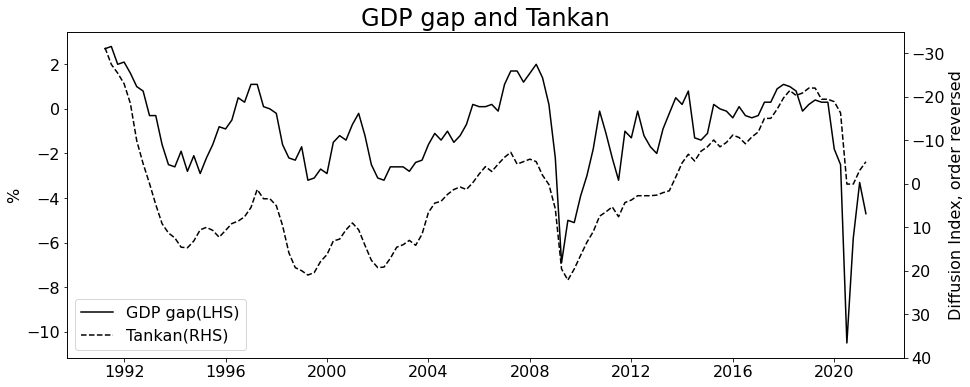

In [17]:
#####
# Draw the graph
#LHS: left hand side
#RHS: Right hand side
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot()
ax1.set_title("GDP gap and Tankan", fontsize=24)
ax1.plot(dti, caogap, label="GDP gap(LHS)", color="black")
ax1.grid(False)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
h1, l1 = ax1.get_legend_handles_labels()
ax2 = ax1.twinx()
ax2.plot(dti, tankan, label="Tankan(RHS)", color="black", linestyle="dashed")
ax2.grid(False)
ax2.tick_params(labelsize=16)
ax2.invert_yaxis()
ax2.set_ylim(40, -35)
ax2.set_ylabel("Diffusion Index, order reversed", fontsize=16)
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower left", fontsize=16)

The following code conducts forecast by AR(p) model at first, then forecast by Tankan, and conduct a DM test at last. Besides, since the loss function of DM test statistic could be MSFE or MAFE, so we made it selectable. Figure 3.4 is computed with the results of DM test and modified DM test with selecting MSFE as loss function MSFE.

In [18]:
# Code 3.5
# DM test
# Forecast model 1: forecast by AR(p) mdoel
predict_result1_list, sqe_result1_list, aic_result1_list = [], [], []
PERIOD = 40  # Sample size of training data（40 quarters）
H = 1  # Forecast horizon（1 quarter）
MAX_L = 4  # Maximum lag order of AR model（4 quarter）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)

for l in range(1, MAX_L + 1):
    predict_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    sqe_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    aic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    for i in range((nsample - H) - PERIOD - (MAX_L - 1)):
        train_x, test_x = pd.DataFrame(), pd.DataFrame()
        for ll in range(1, l + 1):
            # Training data
            train_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[i + l - ll : i + l - ll + PERIOD]
                    ).to_numpy()
                )
            )
            train_x = pd.concat([train_x, train_x_lagged], axis=1)
            train_y = data_y[i + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
            # Test data
            test_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[
                            i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                        ]
                    ).to_numpy()
                )
            )
            test_x = pd.concat([test_x, test_x_lagged], axis=1)
            test_y = data_y[
                i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
            ]
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_hat = model.predict(train_x)
        sse = ((train_y - y_hat) ** 2).sum(axis=0)
        aic = math.log(sse / len(train_y)) + (l + 1) * 2 / len(train_y)
        forecast = model.predict(test_x)
        sqe = ((test_y - forecast) ** 2).sum(axis=0)
        aic_result[i], predict_result[i], sqe_result[i] = aic, forecast, sqe

    predict_result1_list.append(predict_result)
    sqe_result1_list.append(sqe_result)
    aic_result1_list.append(aic_result)

# Select lag order by AIC
trim_aic1, trim_predict1, trim_sqe1 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i in range(MAX_L):
    trim_aic1[i] = aic_result1_list[i]
    trim_predict1[i] = predict_result1_list[i]
    trim_sqe1[i] = sqe_result1_list[i]

d_length = nsample - H - PERIOD - MAX_L + 1
best_aic_lag1, best_aic_predict1, best_aic_sqe1 = (
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
)
for i in range(d_length):
    best_aic_lag1[i] = trim_aic1.iloc[i, :].idxmin() + 1
    best_aic_predict1[i] = trim_predict1.iloc[i, trim_aic1.iloc[i, :].idxmin()]
    best_aic_sqe1[i] = trim_sqe1.iloc[i, trim_aic1.iloc[i, :].idxmin()]


# Forecast model 2: forecast by Tankan
predict_result2_list, sqe_result2_list, aic_result2_list = [], [], []
PERIOD = 40  # Sample size of training data（40 quarters）
H = 1  # Forecast horizon（1 quarter）
MAX_L = 4  # Maximum lag order of AR model（4 quarter）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(tankan)
nsample = len(data_x)

for l in range(1, MAX_L + 1):
    predict_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    sqe_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    aic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    for i in range((nsample - H) - PERIOD - (MAX_L - 1)):
        train_x, test_x = pd.DataFrame(), pd.DataFrame()
        for ll in range(1, l + 1):
            # Training data
            train_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[i + l - ll : i + l - ll + PERIOD]
                    ).to_numpy()
                )
            )
            train_x = pd.concat([train_x, train_x_lagged], axis=1)
            train_y = data_y[i + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
            # Test data
            test_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[
                            i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                        ]
                    ).to_numpy()
                )
            )
            test_x = pd.concat([test_x, test_x_lagged], axis=1)
            test_y = data_y[
                i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
            ]
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_hat = model.predict(train_x)
        sse = ((train_y - y_hat) ** 2).sum(axis=0)
        aic = math.log(sse / len(train_y)) + (l + 1) * 2 / len(train_y)
        forecast = model.predict(test_x)
        sqe = ((test_y - forecast) ** 2).sum(axis=0)
        aic_result[i], predict_result[i], sqe_result[i] = aic, forecast, sqe

    predict_result2_list.append(predict_result)
    sqe_result2_list.append(sqe_result)
    aic_result2_list.append(aic_result)

# Select lag order by AIC
d_length = nsample - H - PERIOD - MAX_L + 1
trim_aic2, trim_predict2, trim_sqe2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i in range(MAX_L):
    trim_aic2[i] = aic_result2_list[i]
    trim_predict2[i] = predict_result2_list[i]
    trim_sqe2[i] = sqe_result2_list[i]

best_aic_lag2, best_aic_predict2, best_aic_sqe2 = (
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
)
for i in range(d_length):
    best_aic_lag2[i] = trim_aic2.iloc[i, :].idxmin() + 1
    best_aic_predict2[i] = trim_predict2.iloc[i, trim_aic2.iloc[i, :].idxmin()]
    best_aic_sqe2[i] = trim_sqe2.iloc[i, trim_aic2.iloc[i, :].idxmin()]


# Criteria to conduct a DM test(select MSFE or MAFE)
crit = str(input("Select the loss function(MSFE or MAFE): "))
actual_lst = np.ravel(data_y[H + PERIOD + MAX_L - 1 :])
pred1_lst, pred2_lst = best_aic_predict1, best_aic_predict2
e1_lst, e2_lst, d_lst = [], [], []
actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
tlen = float(len(actual_lst))
if crit == "MSFE":
    for actual, p1, p2 in zip(actual_lst, pred1_lst, pred2_lst):
        e1_lst.append((actual - p1) ** 2)
        e2_lst.append((actual - p2) ** 2)
    for e1, e2 in zip(e1_lst, e2_lst):
        d_lst.append(e1 - e2)
elif crit == "MAFE":
    for actual, p1, p2 in zip(actual_lst, pred1_lst, pred2_lst):
        e1_lst.append(abs(actual - p1))
        e2_lst.append(abs(actual - p2))
    for e1, e2 in zip(e1_lst, e2_lst):
        d_lst.append(e1 - e2)
mean_d = pd.Series(d_lst).mean()


def autocovariance(xi, n, k, xs):
    autocov = 0
    tlen = float(n)
    for i in np.arange(0, n - k):
        autocov += ((xi[i + k]) - xs) * (xi[i] - xs)
    return (1 / tlen) * autocov


gamma = []
for lag in range(0, H):
    gamma.append(autocovariance(d_lst, len(d_lst), lag, mean_d))
v_d = (gamma[0] + 2 * sum(gamma[1:])) / tlen
dm_stat = v_d ** (-0.5) * mean_d
pvalue_dm = 2 * norm.cdf(-abs(dm_stat), loc=0, scale=1)
mdm_stat = ((tlen + 1 - 2 * H + H * (H - 1) / tlen) / tlen) ** (0.5) * dm_stat
pvalue_mdm = 2 * t.cdf(-abs(mdm_stat), df=tlen - 1)

# Output DM test statistic and p value
dm_return = collections.namedtuple("dm_return", "DM p_value")
rt = dm_return(DM=dm_stat, p_value=pvalue_dm)
mrt = dm_return(DM=mdm_stat, p_value=pvalue_mdm)
print(f"DM test:{rt}")
print(f"modified DM test:{mrt}")

Select the loss function(MSFE or MAFE): MSFE
DM test:dm_return(DM=0.6764679574414421, p_value=0.49874358337525937)
modified DM test:dm_return(DM=0.6720609531515023, p_value=0.5035828900065175)


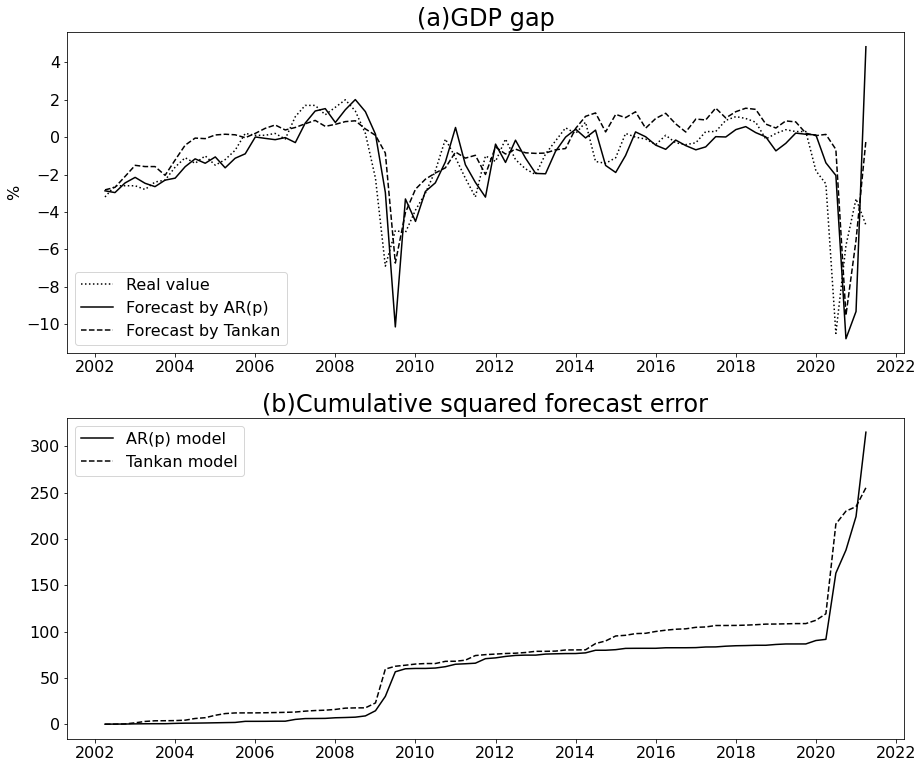

In [19]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)GDP gap", fontsize=24)
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], actual_lst, label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], pred1_lst, label="Forecast by AR(p)", color="black")
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], pred2_lst, label="Forecast by Tankan", color="black", linestyle="dashed")
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Cumulative squared forecast error", fontsize=24)
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], best_aic_sqe1.cumsum(), label="AR(p) model", color="black")
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], best_aic_sqe2.cumsum(), label="Tankan model", color="black", linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

Next, we want to introduce forecast by VAR model. Here, we use two variables, the GDP gap from the Cabinet Office and the inflation rate calculated from the Consumer Price Index from the Ministry of Internal Affairs and Communications, to make forecasts with the VAR model. First, load and data and compute Figure 3.5.

In [20]:
# プログラム3.6
# データの読み込み
cpi = pd.read_excel("data_3_eng.xlsx", sheet_name="CPI", header=[0])
infl = cpi.iloc[:, 1]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="QS")

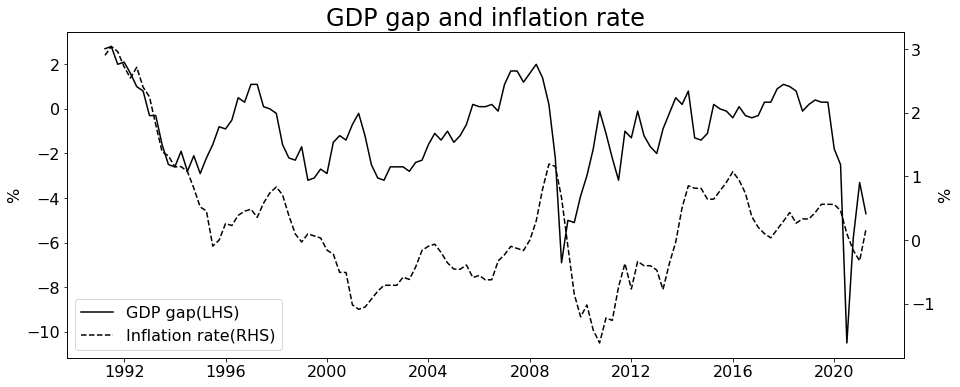

In [22]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot()
ax1.set_title("GDP gap and inflation rate", fontsize=24)
ax1.plot(dti, caogap, label="GDP gap(LHS)", color="black")
ax1.grid(False)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
h1, l1 = ax1.get_legend_handles_labels()
ax2 = ax1.twinx()
ax2.plot(dti, infl, label="Inflation rate(RHS)", color="black", linestyle="dashed")
ax2.grid(False)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("%", fontsize=16)
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower left", fontsize=16)

The VAR(p) model is estimated using GDP gap and inflation data from 1Q1991 to 4Q2018, and forecasts are made from 1Q2019 (one period ahead), to 1Q2021 (nine periods ahead). The maximum lag order of the VAR(p) model is set to 12 in the "maxlags" section of the code, and AIC is set to select the lag order in the "ic" section. As a result, Figure 3.6 can be computed.

In [24]:
# Code 3.7
# VAR forecast
data = np.zeros([len(gap), 2])
data[:, 0], data[:, 1] = caogap, infl
MAX_H = 9  # Maximum forecast horizon（9 quarters）
CONFIDENCE_LEVEL = 0.95  # Confidence coefficient

# Estimation of VAR model
model = VAR(data[:-MAX_H])
result = model.fit(maxlags=12, ic="aic")
lag_order = result.k_ar
print(f"Lag order: {lag_order}")

predict = result.forecast(data[-(lag_order + MAX_H) : -MAX_H], MAX_H)
var_forecast = (
    pd.concat([pd.DataFrame(data[0:-MAX_H]), pd.DataFrame(predict)], axis=0)
).to_numpy()
lbound, ubound = sp.stats.norm.interval(alpha=CONFIDENCE_LEVEL, loc=0, scale=1)
conf_result = np.zeros([MAX_H + 1, 2])
for h in range(1, MAX_H + 1, 1):
    list_fitted1 = []
    list_fitted2 = []
    for i in range(0, len(data) - (lag_order + h - 1) * 2, 1):
        fitted = result.forecast(data[i : i + lag_order], h)
        list_fitted1.append(fitted[h - 1, 0])
        list_fitted2.append(fitted[h - 1, 1])
        se1 = np.std(data[lag_order + h - 1 : i + lag_order + h, 0] - list_fitted1)
        se2 = np.std(data[lag_order + h - 1 : i + lag_order + h, 1] - list_fitted2)
    conf_result[h, 0], conf_result[h, 1] = se1 * ubound, se2 * ubound

Lag order: 2


Text(0, 0.5, '%')

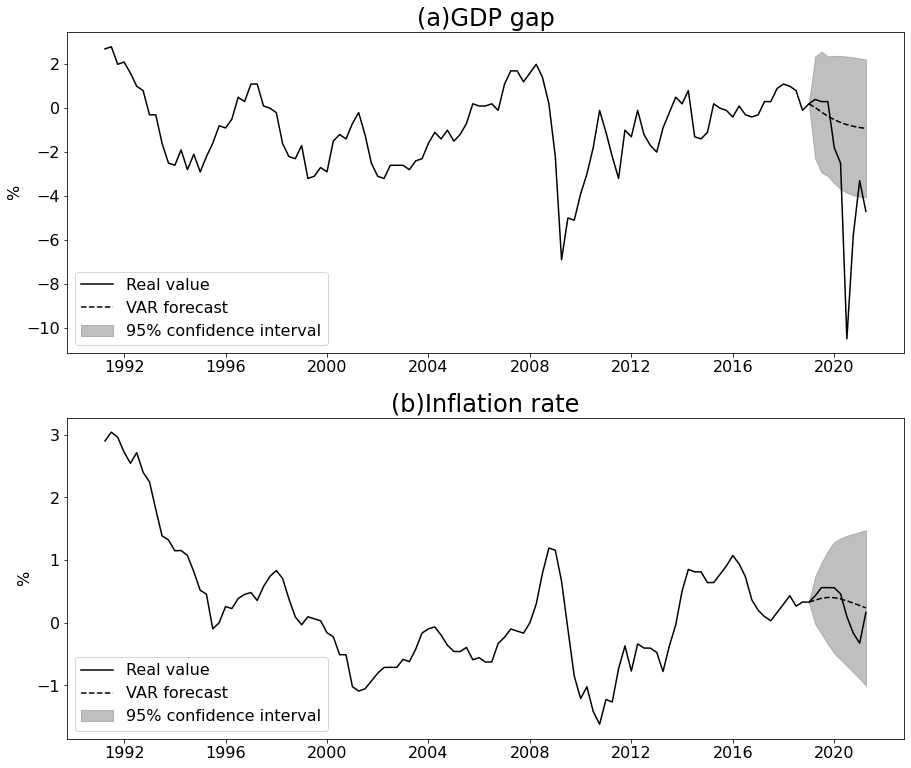

In [28]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)GDP gap", fontsize=24)
ax1.plot(dti, caogap, label="Real value", color="black")
ax1.plot(dti[-MAX_H - 1 :], var_forecast[-MAX_H - 1 :, 0], label="VAR forecast", color="black", linestyle="dashed")
ax1.fill_between(
    dti[-MAX_H - 1 :],
    var_forecast[-MAX_H - 1 :, 0] + conf_result[:, 0],
    var_forecast[-MAX_H - 1 :, 0] - conf_result[:, 0],
    color="grey",
    alpha=0.5,
    label="95% confidence interval",
)
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Inflation rate", fontsize=24)
ax2.plot(dti, infl, label="Real value", color="black")
ax2.plot(dti[-MAX_H - 1 :], var_forecast[-MAX_H - 1 :, 1], label="VAR forecast", color="black", linestyle="dashed")
ax2.fill_between(
    dti[-MAX_H - 1 :],
    var_forecast[-MAX_H - 1 :, 1] + conf_result[:, 1],
    var_forecast[-MAX_H - 1 :, 1] - conf_result[:, 1],
    color="grey",
    alpha=0.5,
    label="95% confidence interval",
)
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("%", fontsize=16)

We conduct the Granger causality test with data from 1Q1999 to 1Q 2021. The following code shows the results of using F test statistic and Wald test statistic seperately.

In [29]:
# Code 3.8
# Estimation of VAR with all sample data
model = VAR(data)
result = model.fit(maxlags=12, ic="aic")
print(f"Lag order: {result.k_ar}")

# Granger causality test（F test statistic, a significance level of 5%）
# Null hypothesis「y2(inflatio rate) does not Granger-cause y1(GDP gap).」
test12_outcome = result.test_causality("y1", "y2", kind="f", signif=0.05)
print(test12_outcome.summary())
# Null hypothesis「y1(GDP gap) does not Granger-cause y2(inflatio rate).」
test21_outcome = result.test_causality("y2", "y1", kind="f", signif=0.05)
print(test21_outcome.summary())

# Granger causality test（Wald test statistic, a significance level of 5%）
# Null hypothesis「y2(inflatio rate) does not Granger-cause y1(GDP gap).」
test12_outcome = result.test_causality("y1", "y2", kind="wald", signif=0.05)
print(test12_outcome.summary())
# Null hypothesis「y1(GDP gap) does not Granger-cause y2(inflatio rate).」
test21_outcome = result.test_causality("y2", "y1", kind="wald", signif=0.05)
print(test21_outcome.summary())

Lag order: 5
Granger causality F-test. H_0: y2 does not Granger-cause y1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.5626          2.257   0.729 (5, 210)
----------------------------------------------
Granger causality F-test. H_0: y1 does not Granger-cause y2. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.054          2.257   0.000 (5, 210)
----------------------------------------------
Granger causality Wald-test. H_0: y2 does not Granger-cause y1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.813          11.07   0.729  5
----------------------------------------
Granger causality Wald-test. H_0: y1 does not Granger-cause y2. Conclusion: reject H_0 at 5% signi

Forecast with mixed-frequency data. We use index of industrial production (iip) and indices of tertiary industry activity (sai) as high frequency (monthly) series, GDP as low frequency (quarterly) series. First of all, load the data.

In [30]:
# プログラム3.9
# Forecasting with mixed-frequency data
# Load the data
data = pd.read_excel("data_3_eng.xlsx", sheet_name="Mixed-frequency", header=[0])
data_m, data_q = data.iloc[:, 1 : 2 + 1], data.iloc[:, 4 : 4 + 1]
data_q = data_q.dropna()
mdlen, qdlen = len(data_m), len(data_q)
mdti = pd.date_range("1994-01-01", periods=mdlen, freq="MS")
qdti = pd.date_range("1994-01-01", periods=qdlen, freq="QS")
data_m, data_q = np.log(data_m).diff(1), np.log(data_q).diff(1)

PERIOD = 60  # Sample size of training data（60 quarters=180 months）

# Estimate forecasting by AR(1) model for comparison
predict_result10_list = []
H = 1  # Forecast horizon（1 quarter）
L = 1  # Lag order（1 quarter）
data_y = pd.DataFrame(data_q.iloc[1:,0])
data_x = pd.DataFrame(data_q.iloc[1:,0])
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    # Training data
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[i + H + (L - 1) : i + H + PERIOD + (L - 1)]
    # Test data
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1]
    predict_result[i], sqe_result[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result10_list.append(predict_result)

Bridge model can be computed with following code.

In [31]:
# Code 3.10
# Bridge model
predict_result1_list, predict_result2_list, predict_result3_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):
    df_hatdata = data_m.iloc[3 * k : 3 * (k + PERIOD + 1), :]
    nd_hatdata = df_hatdata.to_numpy()

    # Create M3 type bridge model
    mqdata_before3 = df_hatdata.rolling(window=3, center=False).sum() / 3
    mqdata3 = np.zeros([PERIOD + 1, 2])
    for i in range(PERIOD + 1):
        mqdata3[i, :] = mqdata_before3.iloc[3 * (i + 1) - 1, :]
    x3 = mqdata3[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x3, y)
    predict_result[3 * (k - 1) + 2] = model.predict(mqdata3[PERIOD : PERIOD + 1, :])
    predict_result3_list.append(predict_result[(k - 1) * 3 + 2])

    # Create M2 type bridge model
    fitted21 = pd.DataFrame(np.zeros([1, 2]))
    for j in range(2):
        tempx21 = pd.DataFrame(df_hatdata.iloc[:-1, j].to_numpy())
        tempy21 = pd.DataFrame(df_hatdata.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx21, tempy21)
        fitted21.iloc[0, j] = model.intercept_ + model.coef_ * df_hatdata.iloc[-2, j]
    hatdata2 = pd.concat([pd.DataFrame(nd_hatdata[:-1, :]), fitted21], axis=0)
    mqdata_before2 = hatdata2.rolling(window=3, center=False).sum() / 3
    mqdata2 = np.zeros([PERIOD + 1, 2])
    for i in range(PERIOD + 1):
        mqdata2[i, :] = mqdata_before2.iloc[3 * (i + 1) - 1, :]
    x2 = mqdata2[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x2, y)
    predict_result[3 * (k - 1) + 1] = model.predict(mqdata2[PERIOD : PERIOD + 1, :])
    predict_result2_list.append(predict_result[(k - 1) * 3 + 1])

    # Create M1 type bridge model
    fitted11 = pd.DataFrame(np.zeros([1, 2]))
    fitted12 = pd.DataFrame(np.zeros([1, 2]))
    for j in range(2):
        tempx11 = pd.DataFrame(df_hatdata.iloc[:-1, j].to_numpy())
        tempy11 = pd.DataFrame(df_hatdata.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx11, tempy11)
        fitted11.iloc[0, j] = model.intercept_ + model.coef_ * df_hatdata.iloc[-3, j]
        tempx12 = pd.DataFrame(df_hatdata.iloc[:-2, j].to_numpy())
        tempy12 = pd.DataFrame(df_hatdata.iloc[2:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx12, tempy12)
        fitted12.iloc[0, j] = model.intercept_ + model.coef_ * df_hatdata.iloc[-3, j]
    hatdata1 = pd.concat([pd.DataFrame(nd_hatdata[:-2, :]), fitted11, fitted12], axis=0)
    mqdata_before1 = hatdata1.rolling(window=3, center=False).sum() / 3
    mqdata1 = np.zeros([PERIOD + 1, 2])
    for i in range(PERIOD + 1):
        mqdata1[i, :] = mqdata_before1.iloc[3 * (i + 1) - 1, :]
    x1 = mqdata1[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x1, y)
    predict_result[3 * (k - 1)] = model.predict(mqdata1[PERIOD : PERIOD + 1, :])
    predict_result1_list.append(predict_result[(k - 1) * 3])

MIDAS model can be computed with following code.

In [32]:
# Code 3.11
# MIDAS model
predict_result4_list, predict_result5_list, predict_result6_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):
    # Estimate parameters by nonlinear least squares method
    def fit_func(parameter, xx, y):
        x11, x12, x13, x21, x22, x23 = xx
        a, b, c, d, e = parameter
        residual = (
            y
            - a
            - b
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x13
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x12
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x11
            )
            - e
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x23
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x22
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x21
            )
        )
        return residual

    
    parameter0 = [0, 0, 0, 0, 0]

    # Create M3 type MIDAS model
    y = np.ravel(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 1].to_numpy()
    result = sp.optimize.leastsq(
        fit_func, parameter0, args=((x11, x12, x13, x21, x22, x23), y)
    )
    a_fit, b_fit, c_fit, d_fit, e_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
    )
    predict_result[3 * (k - 1) + 2] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 2, 0]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 0]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 0]
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 2, 1]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 1]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 1]
        )
    )
    predict_result6_list.append(predict_result[3 * (k - 1) + 2])

    # Create M2 type MIDAS model
    y = np.ravel(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    result = sp.optimize.leastsq(
        fit_func, parameter0, args=((x13, x11, x12, x23, x21, x22), y)
    )
    a_fit, b_fit, c_fit, d_fit, e_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
    )
    predict_result[3 * (k - 1) + 1] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 0]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 0]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 0]
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 1]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 1]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 1]
        )
    )
    predict_result5_list.append(predict_result[3 * (k - 1) + 1])

    # Create M1 type MIDAS model
    y = np.ravel(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    result = sp.optimize.leastsq(
        fit_func, parameter0, args=((x12, x13, x11, x22, x23, x21), y)
    )
    a_fit, b_fit, c_fit, d_fit, e_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
    )
    predict_result[3 * (k - 1)] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 0]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 0]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 2, 0]
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 1]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 1]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 2, 1]
        )
    )
    predict_result4_list.append(predict_result[3 * (k - 1)])

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


U-MIDAS model can be computed with following code.

In [33]:
# Code 3.12
# U-MIDAS model
predict_result7_list, predict_result8_list, predict_result9_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):

    # Create M3 type U-MIDAS model
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 1].to_numpy()
    x = pd.concat(
        [
            pd.DataFrame(x11),
            pd.DataFrame(x12),
            pd.DataFrame(x13),
            pd.DataFrame(x21),
            pd.DataFrame(x22),
            pd.DataFrame(x23),
        ],
        axis=1,
    )
    model = LinearRegression()
    model.fit(x, y)
    x11_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 0]])
    x12_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 0]])
    x13_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 2, 0]])
    x21_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 1]])
    x22_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 1]])
    x23_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 2, 1]])
    x_p = pd.concat([x11_p, x12_p, x13_p, x21_p, x22_p, x23_p], axis=1)
    predict_result[3 * (k - 1) + 2] = model.predict(x_p)
    predict_result9_list.append(predict_result[3 * (k - 1) + 2])

    # Create M2 type U-MIDAS model
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    x = pd.concat(
        [
            pd.DataFrame(x13),
            pd.DataFrame(x11),
            pd.DataFrame(x12),
            pd.DataFrame(x23),
            pd.DataFrame(x21),
            pd.DataFrame(x22),
        ],
        axis=1,
    )
    model = LinearRegression()
    model.fit(x, y)
    x11_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 0]])
    x12_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 0]])
    x13_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 0]])
    x21_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 1]])
    x22_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 1]])
    x23_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 1]])
    x_p = pd.concat([x13_p, x11_p, x12_p, x23_p, x21_p, x22_p], axis=1)
    predict_result[3 * (k - 1) + 1] = model.predict(x_p)
    predict_result8_list.append(predict_result[3 * (k - 1) + 1])

    # Create M1 type U-MIDAS model
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    x = pd.concat(
        [
            pd.DataFrame(x12),
            pd.DataFrame(x13),
            pd.DataFrame(x11),
            pd.DataFrame(x22),
            pd.DataFrame(x23),
            pd.DataFrame(x21),
        ],
        axis=1,
    )
    model = LinearRegression()
    model.fit(x, y)
    x11_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 0]])
    x12_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 2, 0]])
    x13_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 0]])
    x21_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 1]])
    x22_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 2, 1]])
    x23_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 1]])
    x_p = pd.concat([x12_p, x13_p, x11_p, x22_p, x23_p, x21_p], axis=1)
    predict_result[3 * (k - 1)] = model.predict(x_p)
    predict_result7_list.append(predict_result[3 * (k - 1)])

Figure 3.7 can be created by summarizing the results to this point.

Text(0, 0.5, '%')

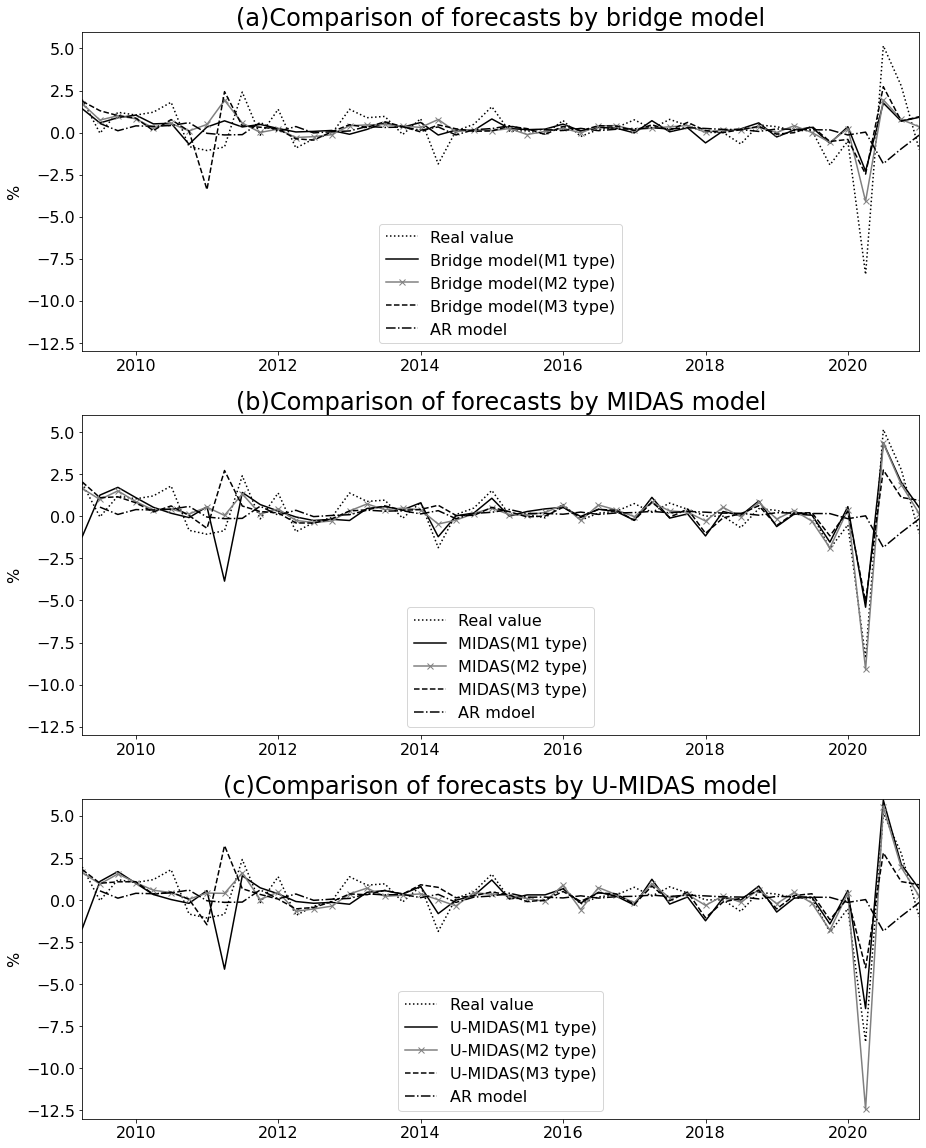

In [36]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)Comparison of forecasts by bridge model", fontsize=24)
ax1.plot(qdti[PERIOD + 1 :], data_q.iloc[PERIOD + 1 :, 0] * 100, label="Real value", color="black", linestyle="dotted")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result1_list) * 100, label="Bridge model(M1 type)", color="black")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result2_list) * 100, label="Bridge model(M2 type)", color="grey", marker="x")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result3_list) * 100, label="Bridge model(M3 type)", color="black", linestyle="dashed")
ax1.plot(qdti[PERIOD + 2 :], np.ravel(predict_result10_list) * 100, label="AR model", color="black", linestyle="dashdot")
ax1.legend(loc="lower center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax1.set_ylim(-13, 6)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Comparison of forecasts by MIDAS model", fontsize=24)
ax2.plot(qdti[PERIOD + 1 :], data_q.iloc[PERIOD + 1 :, 0] * 100, label="Real value", color="black", linestyle="dotted")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result4_list) * 100, label="MIDAS(M1 type)", color="black")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result5_list) * 100, label="MIDAS(M2 type)", color="grey", marker="x")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result6_list) * 100, label="MIDAS(M3 type)", color="black", linestyle="dashed")
ax2.plot(qdti[PERIOD + 2 :], np.ravel(predict_result10_list) * 100, label="AR mdoel", color="black", linestyle="dashdot")
ax2.legend(loc="lower center", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax2.set_ylim(-13, 6)
ax2.set_ylabel("%", fontsize=16)
ax3.set_title("(c)Comparison of forecasts by U-MIDAS model", fontsize=24)
ax3.plot(qdti[PERIOD + 1 :], data_q.iloc[PERIOD + 1 :, 0] * 100, label="Real value", color="black", linestyle="dotted")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result7_list) * 100, label="U-MIDAS(M1 type)", color="black")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result8_list) * 100, label="U-MIDAS(M2 type)", color="grey", marker="x")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result9_list) * 100, label="U-MIDAS(M3 type)", color="black", linestyle="dashed")
ax3.plot(qdti[PERIOD + 2 :], np.ravel(predict_result10_list) * 100, label="AR model", color="black", linestyle="dashdot")
ax3.legend(loc="lower center", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax3.set_ylim(-13, 6)
ax3.set_ylabel("%", fontsize=16)

Composite forecast can be computed by the following code. Firstly,we take GDP gap as target variable, and forecast with 6 forecasting models one by one(AR(1)model, model with Tankan as predictor, model with unemployment rate as predictor, model with  active job openings-to-applicants ratio as predictor, model with index of industrial production as predictor, model with indices of tertiary industry activity as predictor). Then, with the 6 different forecastings, we calculate the composite forecast by arithmetic average, the composite forecast by equation(3.25), and the composite by OLS, and create FIgure 3.8 at last.

In [37]:
# Code 3.10
# We use 6 forecasting methods to forecast GDP gap.
# Load the data
labor = pd.read_excel("data_3_eng.xlsx", sheet_name="ur&ota", header=[0])
activity = pd.read_excel(
    "data_3_eng.xlsx", sheet_name="IIP&ITA", header=[0]
)
ur, ota = labor.iloc[:, 1], labor.iloc[:, 2]
iip, sai = activity.iloc[:, 1], activity.iloc[:, 2]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="Q")
PERIOD = 40  # Sample size of training data（40 quarters）
H = 1  # Forecast horizon（1 quarter）

# Forecast 1: forecast by AR(1) model
predict_result1_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # Training data
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # Estimation of model
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result1_list.append(predict_result)

# Forecast 2: forecast by tankan
predict_result2_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(tankan)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # Training data
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # Estimation of model
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result2_list.append(predict_result)

# Forecast 3: forecast by unemployment rate（ur).
predict_result3_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(ur)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # Training data
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # Estimation of model
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result3_list.append(predict_result)

# Forecast 4: forecast by active job openings-to-applicants ratio
predict_result4_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(ota)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # Training data
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # Estimation of model
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result4_list.append(predict_result)

# Forecast 5: forecast by index of industrial production（iip）
predict_result5_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(iip)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # Training data
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # Estimation of model
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result5_list.append(predict_result)

# Forecast 6: forecast by indices of tertiary industry activity（sai）
predict_result6_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(sai)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # Training data
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # Estimation of model
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result6_list.append(predict_result)

# Aggregate real and forecasted values
pack = pd.concat(
    [
        pd.DataFrame(caogap[h + PERIOD :].to_numpy()),
        pd.DataFrame(predict_result1_list).T,
        pd.DataFrame(predict_result2_list).T,
        pd.DataFrame(predict_result3_list).T,
        pd.DataFrame(predict_result4_list).T,
        pd.DataFrame(predict_result5_list).T,
        pd.DataFrame(predict_result6_list).T,
    ],
    axis=1,
)


# Composite forecast by arithmetic average
def compute_am(pack):
    am_weight = np.zeros([len(pack.T) - 1, 1])
    for i in range(0, len(am_weight), 1):
        am_weight[i] = 1 / (len(pack.T) - 1)
    fitted_am = np.mean(pack.iloc[:, 1 : len(pack.T)], axis=1)
    return fitted_am, am_weight


# Optimal combined forecast by Bates and Granger (1969)
def compute_bg(pack):
    fitted_bg = np.zeros([len(pack), 1])
    sigma = np.zeros([len(pack.T) - 1, 1])
    bg_weight = np.zeros([len(pack.T) - 1, 1])
    for i in range(1, len(pack.T), 1):
        x = pd.DataFrame(pack.iloc[:, i])
        y = pd.DataFrame(pack.iloc[:, 0])
        model = LinearRegression()
        model.fit(x, y)
        fv = model.predict(x)
        resid = (y - fv) ** 2
        sigma[i - 1] = (np.sum(resid)) ** (-2)
    bg_weight = sigma / np.sum(sigma)
    for i in range(0, len(pack), 1):
        fitted_bg[i] = np.dot(pack.iloc[i, 1:], bg_weight)
    return fitted_bg, bg_weight


# Optimal combined forecast by OLS
def compute_gr(pack):
    fitted_gr = np.zeros([len(pack), 1])
    dep = pack.iloc[:, 0].to_numpy()
    exp = pack.iloc[:, 1:].to_numpy()
    ax = np.ones([len(pack.T) - 1, 1]).T
    bx = 1
    param_gr = cvxpy.Variable(len(pack.T) - 1)
    objective = cvxpy.sum_squares(dep - exp @ param_gr)
    constraints = [ax @ param_gr == bx, param_gr >= 0]
    prob = cvxpy.Problem(cvxpy.Minimize(objective), constraints)
    prob.solve()
    for i in range(0, len(pack), 1):
        fitted_gr[i] = np.dot(pack.iloc[i, 1:], param_gr.value)
    gr_weight = param_gr.value.reshape([len(pack.T) - 1, 1])
    return fitted_gr, gr_weight


weight_am_list, weight_bg_list, weight_gr_list = [], [], []
am_list, bg_list, gr_list = [], [], []
nsample = len(pd.DataFrame(caogap))
predict_result = np.zeros((nsample - H) - PERIOD)
data_y = pd.DataFrame(caogap)
data_x1 = pd.DataFrame(caogap)
data_x2 = pd.DataFrame(tankan)
data_x3 = pd.DataFrame(ur)
data_x4 = pd.DataFrame(ota)
data_x5 = pd.DataFrame(iip)
data_x6 = pd.DataFrame(sai)
for i in range((nsample - H) - PERIOD):
    pack_train = pd.DataFrame(train_y.to_numpy()).copy()
    pack_test = pd.DataFrame(test_y.to_numpy()).copy()
    pack_test_demean = pd.DataFrame(
        test_y.to_numpy() - np.mean(train_y.to_numpy())
    ).copy()
    # Training data
    train_x1 = data_x1[i : i + PERIOD]
    train_x2 = data_x2[i : i + PERIOD]
    train_x3 = data_x3[i : i + PERIOD]
    train_x4 = data_x4[i : i + PERIOD]
    train_x5 = data_x5[i : i + PERIOD]
    train_x6 = data_x6[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x1 = data_x1[i + PERIOD : i + PERIOD + 1]
    test_x2 = data_x2[i + PERIOD : i + PERIOD + 1]
    test_x3 = data_x3[i + PERIOD : i + PERIOD + 1]
    test_x4 = data_x4[i + PERIOD : i + PERIOD + 1]
    test_x5 = data_x5[i + PERIOD : i + PERIOD + 1]
    test_x6 = data_x6[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    # Estimation of model
    model1 = LinearRegression()
    model2 = LinearRegression()
    model3 = LinearRegression()
    model4 = LinearRegression()
    model5 = LinearRegression()
    model6 = LinearRegression()
    model1.fit(train_x1, train_y)
    model2.fit(train_x2, train_y)
    model3.fit(train_x3, train_y)
    model4.fit(train_x4, train_y)
    model5.fit(train_x5, train_y)
    model6.fit(train_x6, train_y)
    fitted1 = model1.predict(train_x1)
    fitted2 = model2.predict(train_x2)
    fitted3 = model3.predict(train_x3)
    fitted4 = model4.predict(train_x4)
    fitted5 = model5.predict(train_x5)
    fitted6 = model6.predict(train_x6)
    pack_train = pd.concat(
        [
            pd.DataFrame(train_y.to_numpy()),
            pd.DataFrame(fitted1),
            pd.DataFrame(fitted2),
            pd.DataFrame(fitted3),
            pd.DataFrame(fitted4),
            pd.DataFrame(fitted5),
            pd.DataFrame(fitted6),
        ],
        axis=1,
    )
    forecast1 = model1.predict(test_x1)
    forecast2 = model2.predict(test_x2)
    forecast3 = model3.predict(test_x3)
    forecast4 = model4.predict(test_x4)
    forecast5 = model5.predict(test_x5)
    forecast6 = model6.predict(test_x6)
    pack_test = pd.concat(
        [
            pd.DataFrame(test_y.to_numpy()),
            pd.DataFrame(forecast1),
            pd.DataFrame(forecast2),
            pd.DataFrame(forecast3),
            pd.DataFrame(forecast4),
            pd.DataFrame(forecast5),
            pd.DataFrame(forecast6),
        ],
        axis=1,
    )

    #Calculate the weights of combined forecast
    am_weight = compute_am(pack_train)[1]
    bg_weight = compute_bg(pack_train)[1]
    gr_weight = compute_gr(pack_train)[1]
    weight_am_list.append(am_weight.T)
    weight_bg_list.append(bg_weight.T)
    weight_gr_list.append(gr_weight.T)
    
    am = np.dot(pack_test.to_numpy()[0, 1:], am_weight)
    bg = np.dot(pack_test.to_numpy()[0, 1:], bg_weight)
    gr = np.dot(pack_test.to_numpy()[0, 1:], gr_weight)
    am_list.append(am)
    bg_list.append(bg)
    gr_list.append(gr)

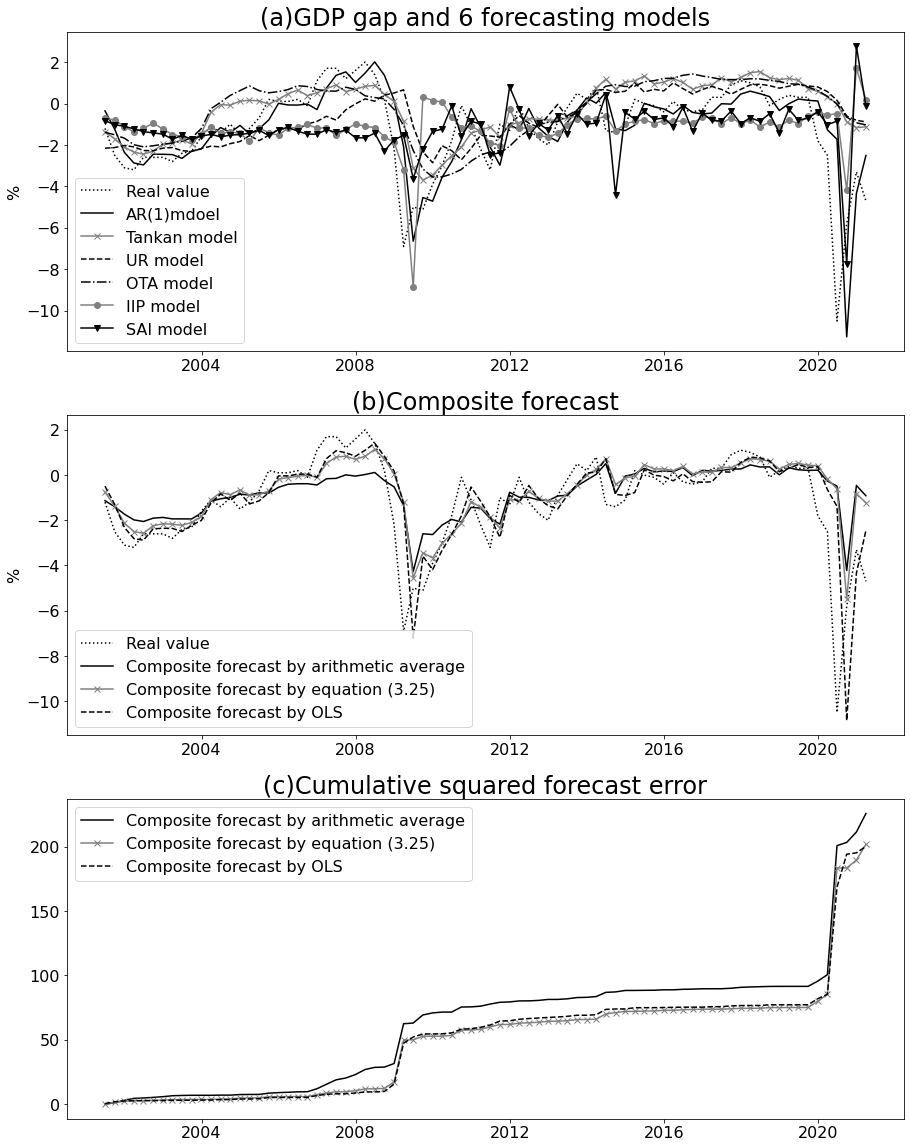

In [38]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)GDP gap and 6 forecasting models", fontsize=24)
ax1.plot(dti[H + PERIOD :], caogap[H + PERIOD :], label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result1_list), label="AR(1)mdoel", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result2_list), label="Tankan model", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result3_list), label="UR model", color="black", linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result4_list), label="OTA model", color="black", linestyle="dashdot")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result5_list), label="IIP model", color="grey", marker="o")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result6_list), label="SAI model", color="black",marker="v")
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Composite forecast", fontsize=24)
ax2.plot(dti[H + PERIOD :], caogap[H + PERIOD :], label="Real value", color="black", linestyle="dotted")
ax2.plot(dti[H + PERIOD :], np.ravel(am_list), label="Composite forecast by arithmetic average", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(bg_list), label="Composite forecast by equation (3.25)", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(gr_list), label="Composite forecast by OLS", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("%", fontsize=16)
ax3.set_title("(c)Cumulative squared forecast error", fontsize=24)
ax3.plot(dti[H + PERIOD :], ((caogap[H+PERIOD:]-np.ravel(am_list))**2).cumsum(), label="Composite forecast by arithmetic average", color='black')
ax3.plot(dti[H + PERIOD :], ((caogap[H+PERIOD:]-np.ravel(bg_list))**2).cumsum(), label="Composite forecast by equation (3.25)", color="grey", marker="x")
ax3.plot(dti[H + PERIOD :], ((caogap[H+PERIOD:]-np.ravel(gr_list))**2).cumsum(),label="Composite forecast by OLS", color="black", linestyle="dashed")
ax3.legend(loc="upper left",fontsize=16)
ax3.tick_params(labelsize=16)

Bayesian model average can be calculated with following code. For Bayesian model average, the MCMC method is used to compute weights for composite forecast. Here, with a data set contains 219 monthly macroeconomic variables for Japan,  we can use a Bayesian model average to calculate the one-month-ahead year-on-year(YoY) change in real wages which is the 130th series in the dataset, from $2^{218}$ combinations of variable choices with the remaining 218 series. And create Figure 3.9 accordingly.

In [43]:
# Code 3.11
# Bayesian model average
# Load the data
ms = pd.read_excel("data_3_eng.xlsx", sheet_name="MS(JJIE2020)", header=[0])
data = pd.concat(
    [pd.DataFrame(ms.iloc[1:, 129].to_numpy()),
     pd.DataFrame(ms.iloc[:-1, :129].to_numpy()),
     pd.DataFrame(ms.iloc[:-1, 130:].to_numpy())],
    axis=1
)
dti = pd.date_range("1974-01-01", periods=len(data), freq="MS")

def compute_bma(pack):
    n = len(pack)
    y = pack.iloc[:, 0]
    xraw = pack.iloc[:, 1:]
    bigk = len(xraw.T)

    mxraw_num = np.mean(xraw)
    mxraw = pd.DataFrame(np.zeros([n, bigk]))
    for i in range(bigk):
        mxraw.iloc[:, i] = np.reshape(np.ones([n, 1]) * mxraw_num.iloc[i], (n))

    xdemean = pd.DataFrame(np.zeros([n, bigk]))
    for i in range(bigk):
        xdemean.iloc[:, i] = xraw.iloc[:, i] - mxraw.iloc[:, i]

    molddraw = np.zeros([bigk, 1])
    xold = np.append(np.ones([n, 1]), xdemean, axis=1)
    xtxinv = np.linalg.inv(np.matmul(xold.T, xold))
    bhat = np.matmul(np.matmul(xtxinv, xold.T), y)
    e = y - np.matmul(xold, bhat)
    sse = np.matmul(e.T, e)
    s2 = sse / (n - bigk - 1)
    bcov = s2 * xtxinv
    bt = pd.DataFrame(np.zeros([bigk + 1, 1]))
    for i in range(1, bigk + 1):
        bt[i] = bhat[i] / math.sqrt(bcov[i, i])
        if abs(bt.iloc[i, i]) > 0.5:
            molddraw[i - 1] = 1
    xold = np.ones([n, 1])
    kold = sum(molddraw) + 1
    for i in range(bigk):
        if molddraw[i] > 0:
            xold = np.append(
                xold, np.reshape((xdemean.iloc[:, i]).to_numpy(), (n, 1)), axis=1
            )
    # Set prior distribution
    if n <= (bigk**2):
        g0 = 1 / (bigk**2)
    else:
        g0 = 1 / n
    yty = np.matmul((y - np.mean(y)).T, (y - np.mean(y)))
    xtxinv = np.linalg.inv(np.matmul(xold.T, xold))
    ymy = np.matmul(y.T, y) - np.matmul(
        np.matmul(np.matmul(np.matmul(y.T, xold), xtxinv), xold.T), y
    )
    g1 = g0 / (g0 + 1)
    g2 = 1 / (g0 + 1)
    lprobold = 0.5 * kold * np.log(g1) - 0.5 * (n - 1) * np.log(g2 * ymy + g1 * yty)
    inccount = np.zeros([bigk, 1])
    msize = 0
    # Select the top 10 models
    top10mod = molddraw
    jj = 1
    while jj < 10:
        top10mod = np.append(top10mod, molddraw, axis=1)
        jj = jj + 1
    lprobtop10 = lprobold * np.ones([10, 1])
    top10count = np.zeros([10, 1])
    b1mo, b2mo = np.zeros([bigk, 1]), np.zeros([bigk, 1])
    nburn, nkeep = 2000, 20000
    nrep = nburn + nkeep
    mnewdraw = np.zeros([len(molddraw), len(molddraw.T)])
    for irep in range(nrep):
        indch = round(bigk * np.random.rand())
        xnew = xold
        for i in range(len(molddraw)):
            mnewdraw[i] = molddraw[i]
        if indch > 0:
            if molddraw[indch - 1] == 1:
                isum = 0
                for i in range(0, indch):
                    isum = isum + molddraw[i]
                xnew = np.append(
                    xold[:, 0 : int(isum)], xold[:, int(isum) + 1 : int(kold)], axis=1
                )
                mnewdraw[indch - 1] = 0
            else:
                isum = 0
                for i in range(0, indch):
                    isum = isum + molddraw[i]
                xnew_before = np.append(
                    xold[:, 0 : int(isum) + 1],
                    np.reshape(xdemean.iloc[:, indch - 1].to_numpy(), (n, 1)),
                    axis=1,
                )
                xnew = np.append(
                    xnew_before, xold[:, int(isum) + 1 : int(kold)], axis=1
                )
                mnewdraw[indch - 1] = 1
        knew = sum(mnewdraw) + 1
        xtxinv = np.linalg.pinv(np.matmul(xnew.T, xnew))
        ymy = np.matmul(y.T, y) - np.matmul(
            np.matmul(np.matmul(np.matmul(y.T, xnew), xtxinv), xnew.T), y
        )
        lprobnew = 0.5 * knew * np.log(g1) - 0.5 * (n - 1) * np.log(g2 * ymy + g1 * yty)
        if np.log(np.random.rand()) < (lprobnew - lprobold):
            xold = xnew
            for i in range(0, len(mnewdraw)):
                molddraw[i] = mnewdraw[i]
            kold = knew
            lprobold = lprobnew
        if irep > nburn:
            for i in range(10):
                if lprobold >= lprobtop10[i]:
                    if (
                        sum(abs(molddraw - np.reshape(top10mod[:, i], (bigk, 1))))
                        < 0.09
                    ):
                        break
                    if i < 9:
                        lprobtop10[i + 1 : 10] = lprobtop10[i:9]
                        top10mod[:, i + 1 : 10] = top10mod[:, i:9]
                        top10count[i + 1 : 10] = top10count[i:9]
                    lprobtop10[i] = lprobold
                    top10mod[:, i] = np.reshape(molddraw, (bigk))
                    top10count[i] = 0
                    break
            for i in range(10):
                temp1 = sum(abs(molddraw - np.reshape(top10mod[:, i], (bigk, 1))))
                if temp1 < 0.01:
                    top10count[i] = top10count[i] + 1
                    break
            inccount = inccount + molddraw
            msize = msize + kold
            q1inv = (1 + g0) * np.matmul(xold.T, xold)
            q0inv = g0 * np.matmul(xold.T, xold)
            q1 = np.linalg.pinv(q1inv)
            b1 = np.matmul(np.matmul(q1, xold.T), y)
            vs2 = np.matmul(
                (y - np.matmul(xold, b1)).T, (y - np.matmul(xold, b1))
            ) + np.matmul(np.matmul(b1.T, q0inv), b1)
            bcov = (vs2 / (n - 2)) * q1
            summer = 0
            for i in range(bigk):
                bc = np.zeros([1, int(kold)])
                if molddraw[i] == 1:
                    summer = summer + 1
                    bc[:, summer] = 1
                    bmean = np.matmul(bc, b1)
                    bvar = np.matmul(np.matmul(bc, bcov), bc.T)
                    b1mo[i] = b1mo[i] + bmean
                    b2mo[i] = b2mo[i] + (bvar + bmean**2)
    inccount_bma = inccount / nkeep
    param_bma = b1mo / nkeep
    fitted_bma = np.zeros([len(xraw), 1])
    for i in range(len(fitted_bma)):
        fitted_bma[i] = np.dot(xdemean.iloc[i, :], param_bma) + np.average(y)
    return fitted_bma, param_bma, inccount_bma


fitted, weight, inccount = compute_bma(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Text(0, 0.5, 'Probability')

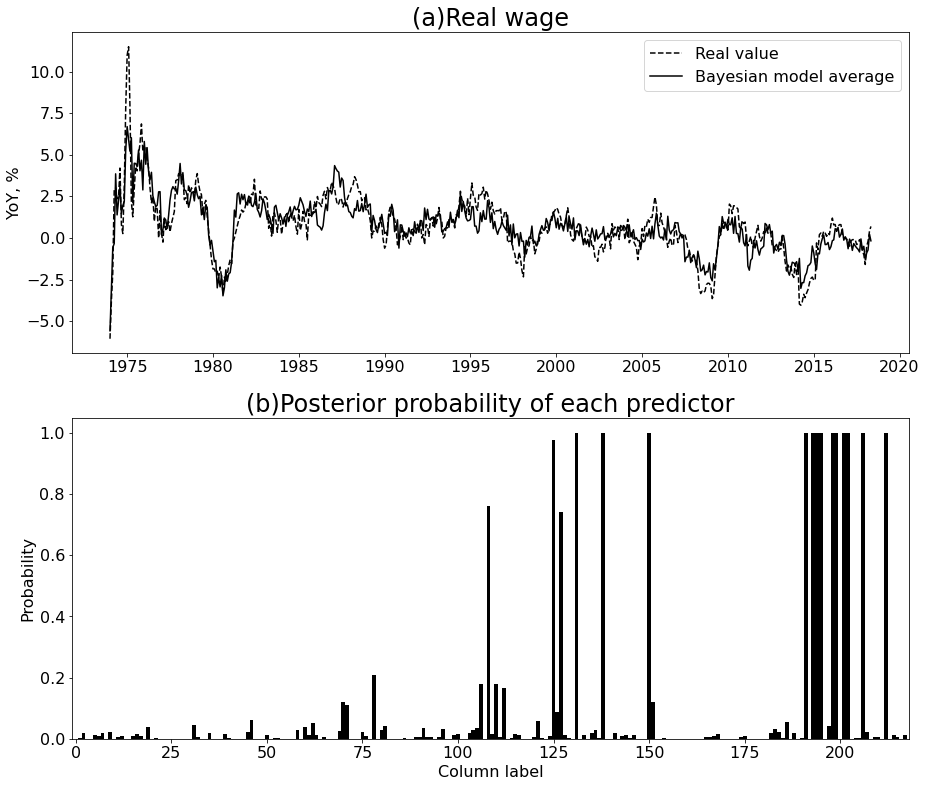

In [44]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)Real wage", fontsize=24)
ax1.plot(dti, ms.x130[1:], label="Real value", color="black", linestyle="dashed")
ax1.plot(dti, fitted, label="Bayesian model average", color="black")
ax1.legend(loc="upper right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("YoY, %", fontsize=16)
ax2.set_title("(b)Posterior probability of each predictor", fontsize=24)
ax2.bar(np.array(range(218)), np.squeeze(inccount), color="black", width=1.0, align="center")
ax2.set_xlim(-1, 218)
ax2.tick_params(labelsize=16)
ax2.set_xlabel("Column label", fontsize=16)
ax2.set_ylabel("Probability", fontsize=16)